In [62]:
import librosa
import numpy as np
from birdnetlib import analyzer, Recording
import operator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy import signal,ndimage

Create the classifier.

In [63]:
an = analyzer.Analyzer(classifier_model_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier.tflite",
                       classifier_labels_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier_Labels.txt")


load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


Some manually defined variables 

In [64]:

af_path = r"C:\Users\plaf\Music\ALAN_training\bug\20230623_190000.WAV"
dur = 3
sr = 48000
fmin = 400
fmax = 4000
dur_birdnet = 3
subseg_dur = .75
margin = .2
min_dur = .5
tstart = 1175.9


Load samples and compute the power spectrogram.
Get the power in time by summing each column of the spectrogram.
Then smooth the power values by applying a gaussian filter.

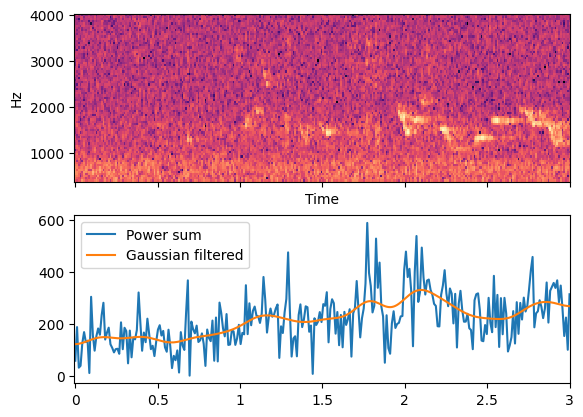

In [65]:

y, sr = librosa.load(af_path, sr=sr, mono=True, res_type="kaiser_fast", offset = tstart, duration=dur)
sample_subseg_dur = int(subseg_dur * sr)
sample_dur = int(dur * sr)
sample_dur_birdnet = int(dur_birdnet * sr)
sample_min_dur = int(min_dur * sr)


n_fft = 512
hop_length = n_fft
S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
S = S[int(n_fft * 2 * fmin / sr) : int(n_fft * 2 * fmax / sr)]
spec = librosa.amplitude_to_db(np.abs(S))
spec_sum = np.sum(spec, axis=0)

l = spec_sum
spec_sum -= np.min(spec_sum)
conv = ndimage.gaussian_filter1d(spec_sum,8)

# Utilities to plot functions easily
tstamps_arr = lambda arr: np.linspace(0, dur, len(arr))
plot_vals = lambda arr: (tstamps_arr(arr), arr)

spec_tstamps = tstamps_arr(spec.T)
y_coords = np.linspace(fmin, fmax, len(spec))




fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, y_coords = y_coords, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].plot(*plot_vals(spec_sum), label="Power sum")
ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
ax[1].legend()
plt.show()

Find the local minima (valleys) and maxima (summits) on the filtered function.  Make sure that there is always a local minima before and after a local maxima by "artificially creating" one at the start and at the end of the audio portion in case the power spectrogram curve sarts, resp ends, with a local maximum.

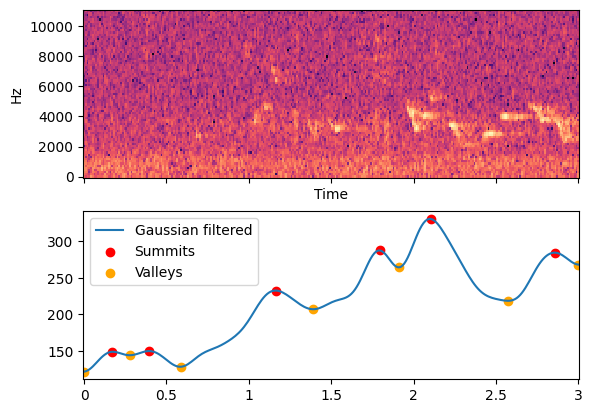

In [66]:
summit = np.zeros_like(conv, dtype=np.bool_)
summit[1:-1] = (conv[:-2] <= conv[1:-1]) & (conv[1:-1] >= conv[2:])
 # Force the existance of only one point in the neighborhood:
summit[1:] &= ~summit[:-1] 

summit_i = np.flatnonzero(summit)

valley = np.zeros_like(summit)
valley[1:-1] = (conv[:-2] >= conv[1:-1]) & (conv[1:-1] <= conv[2:])
 # Force the existance of only one point in the neighborhood:
valley[1:] &= ~valley[:-1] 
valley_i = np.flatnonzero(valley)

# "pre-/append" valley 
valley[0] = len(valley_i) == 0  or summit_i[0] < valley_i[0]
valley[-1] = len(valley_i) == 0 or  summit_i[-1] > valley_i[-1]

valley_i = np.flatnonzero(valley)


fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
ax[1].scatter(tstamps_arr(conv)[summit], conv[summit], c="red", label="Summits")
ax[1].scatter(tstamps_arr(conv)[valley], conv[valley], c="orange", label="Valleys")
ax[1].legend()
plt.show()

Reduce the power sum in the interval between the previous and the next `valley` by the mean of the two. Set the threshold as the mean of the reduced `summit` values, here called `spikes`.

6 6


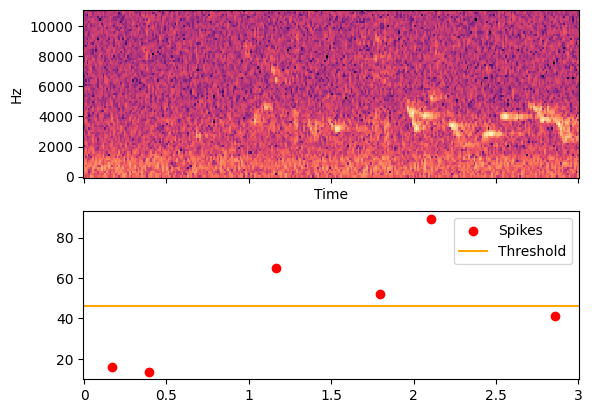

In [67]:

previous_valley = conv[valley_i[:-1]]
next_valley = conv[valley_i[1:]]
d = np.stack([previous_valley, next_valley])
print(len(d[0]), len(conv[summit]))
spikes = conv[summit] - np.mean(d, axis=0)
thresh = np.mean(spikes)

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].scatter(tstamps_arr(conv)[summit], spikes, c="red", label="Spikes")
ax[1].axhline(thresh, c="orange", label="Threshold")
ax[1].legend()
plt.show()


Get the starts and ends of the selections containing the spikes above the threshold by taking the minima and maxima finite difference (1st derivative approximation) in the intervals between the two enclosing valleys.

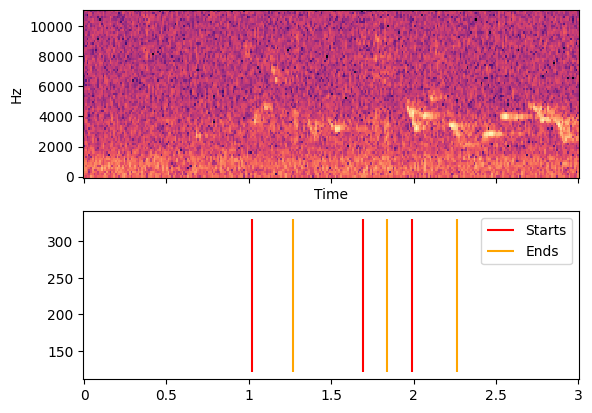

In [68]:

# Find the two enclosing valleys for spikes above threshold
sample_start_mask = np.zeros_like(y, dtype=np.bool_)
sample_start_mask[valley_i[:-1][spikes > thresh]] = True
sample_start_i = np.flatnonzero(sample_start_mask)
sample_end_mask = np.zeros_like(sample_start_mask)
sample_end_mask[valley_i[1:][spikes > thresh]] = True
sample_end_i = np.flatnonzero(sample_end_mask)
dconv = np.diff(conv)

# For all intervals take the position at which the first difference is minimal resp. maximal.
for i, (ssi, sei) in enumerate(zip(sample_start_i, sample_end_i)):
    dconv_ = dconv[ssi:sei]
    sample_start_i[i] = ssi + np.argmax(dconv_)
    sample_end_i[i] = ssi + np.argmin(dconv_)

px_to_sample = len(y) / len(conv)

# Convert from spectrogram column index to samples
# Apply some margin to give some space around the call (more "context" for Birdnet's custom classifier)
subseg_starts = ((sample_start_i) * px_to_sample).astype(np.int64)
subseg_ends =  ((sample_end_i) * px_to_sample).astype(np.int64)

times_plot = tstamps_arr(y)
l = len(times_plot)

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])   
ax[1].vlines(times_plot[np.delete(subseg_starts, subseg_starts>l)], conv.min(), conv.max(), colors="red", label="Starts")
ax[1].vlines(times_plot[np.delete(subseg_ends, subseg_ends>l)], conv.min(), conv.max(), colors="orange", label="Ends")
ax[1].legend()
plt.show()



Finally, pass each detected segment to the BirdNET's custom classifier.

Get all noise chunks

In [69]:
noise = []
for ss, se in zip(subseg_starts[1:], subseg_ends):
    noise.append(y[se:ss])

For each of the obtained segments, but the chunk signal in the middle and pad with the noise.
The noise is created by combining the two noise segments from the list above that are next to the subsegment.
If the noise is too short, concatenate to itself until it reaches the required length.
In case the segment is longer than the allowed BirdNET's duration, take the mid part of it.

[0. 0. 0. ... 0. 0. 0.]


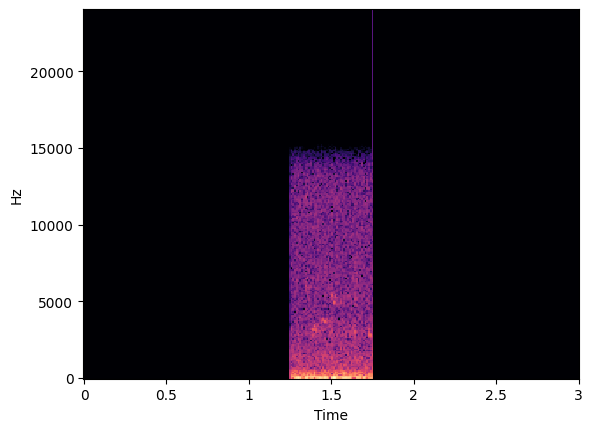

0.75 0.12462424
[0. 0. 0. ... 0. 0. 0.]


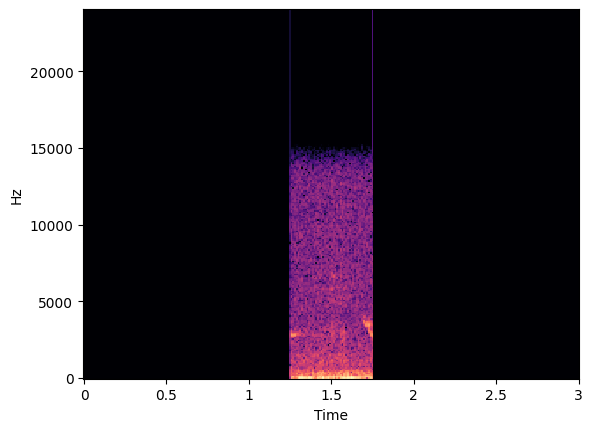

[0. 0. 0. ... 0. 0. 0.]


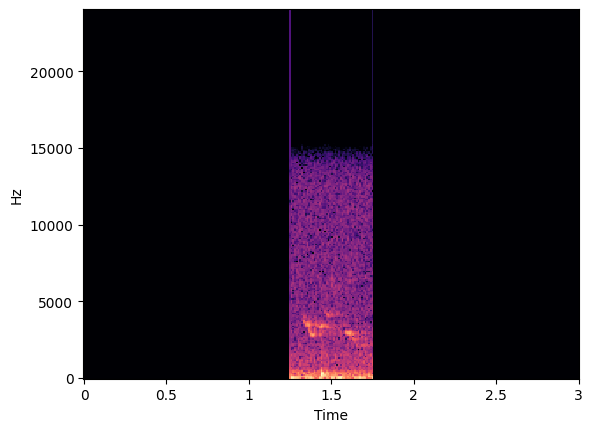

[42893]


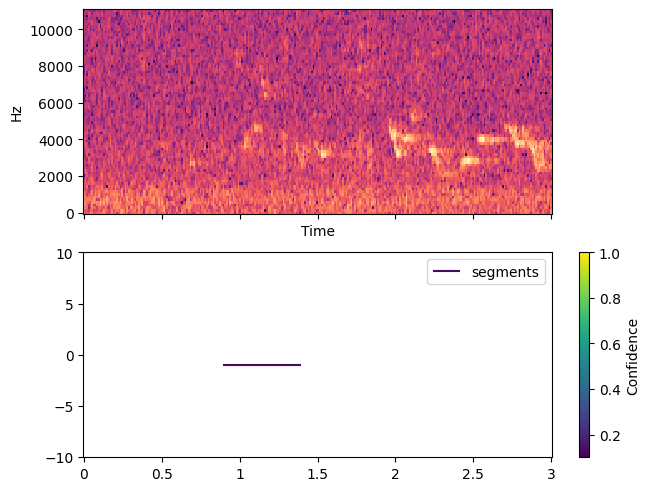

In [70]:

valid_starts = []
valid_ends = []
confidences = []

conf_thresh = .1

for i, (ss, se) in enumerate(zip(subseg_starts, subseg_ends)):
    white_noise = []
    
    if i > 0:
        white_noise.append(noise[i-1])
    
    if i < len(noise) - 1:
        white_noise.append(noise[i+1])
    
    white_noise = np.concatenate(white_noise)

    while len(white_noise) < sample_dur_birdnet:
        white_noise = np.concatenate([white_noise, white_noise])
    
    # white_noise = white_noise[:sample_dur_birdnet]
    std = np.std(y[ss: se])
    mean = np.mean(y[ss: se])
    # white_noise = np.random.normal(mean, std, sample_dur_birdnet)
    # white_noise = (white_noise + (np.cos(white_noise)*std + mean))/2
    # white_noise = np.sin(np.arange(sample_dur_birdnet) / 2 / np.pi / 400) * std + white_noise
    white_noise = np.zeros(sample_dur_birdnet)
    print(white_noise)

    y_subseg = np.array(white_noise)
    dur_subseg = (se - ss) / sr
    
    if dur_subseg < min_dur:
        center = (se + ss) // 2
        ss = center - sample_min_dur // 2
        se = ss + sample_min_dur

    if dur_subseg > dur_birdnet:
        # Make sure that the duration is not longer than BirdNET allows
        center = (se + ss) // 2
        ss = center - sample_dur_birdnet // 2
        se = ss + sample_dur_birdnet

    y_ = y[ss: se]
    center = int(sample_dur_birdnet // 2)
    l_half = int(len(y_) // 2)
    start = center - l_half
    y_subseg[start: start + len(y_)] = y_

    subseg_S = librosa.stft(y_subseg, n_fft=n_fft, hop_length=hop_length)
    subseg_spec = librosa.amplitude_to_db(np.abs(subseg_S))

    librosa.display.specshow(subseg_spec, x_axis='time', y_axis='linear', sr=sr) 
    plt.show()
    plt.close()
    pred = an.predict_with_custom_classifier(y_subseg)[0]

    # Assign scores to labels
    p_labels = dict(zip(an.labels, pred))

    # Sort by score
    p_sorted = sorted(
        p_labels.items(), key=operator.itemgetter(1), reverse=True
    )

    # Filter by recording.minimum_confidence so not to needlessly store full 8K array for each chunk.
    p_sorted = [i for i in p_sorted if i[1] >= conf_thresh]

    if p_sorted:
        valid_starts.append(ss)
        valid_ends.append(se)
        confidences.append(p_sorted[0][1])
        print(subseg_dur,confidences[-1])



valid_starts = np.array(valid_starts)
valid_ends = np.array(valid_ends)
confidences = np.array(confidences)

print(valid_starts)

fig, ax = plt.subplots(nrows=2, sharex=True, layout='constrained')
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])  
y_segments = np.zeros(len(valid_starts))
y_segments[2::3] = 1
y_segments[::3] = -1
selected_cmap = cm.viridis
norm = mpl.colors.Normalize(vmin = conf_thresh, vmax = 1)
m = cm.ScalarMappable(norm=norm, cmap=selected_cmap)
if len(valid_starts) > 0:
    ax[1].hlines(y_segments, times_plot[valid_starts], times_plot[valid_ends], colors=m.to_rgba(confidences), label="segments")
    ax[1].legend()

fig.colorbar(m, ax=ax[1], label="Confidence")
ax[1].set_ylim([-10,10])
plt.show()

